# Welcome to the EEweather Tutorial

This notebook demonstrates using the EEweather package to find and load temperature data that approximates the
unobserved temperature at a building site.

This task is surprisingly nuanced. The problem is that weather stations and buildings are scattered around
and sometimes situations like the following arise when matching a site to an appropriate weather station:

 - site location is not well described (no full address, unknown climate zone)
 - site has no nearby weather stations
 - site has too many nearby weather stations
 - nearby weather stations are in a different climate zone (e.g., right on the coast)
 - nearby weather station has low quality data
 - nearby weather station has low frequency data
 - nearby weather station has no weather normal data
 
EEweather provides tools to help address some of these issues. This tutorial walks through those tools and provides
examples of usage. It is best used in combination with the [online documentation](http://eeweather.openee.io).
 
Many building sites are 
If the only building sites for which you were interested in finding an accurate source of data were located within a from which to load weather(using lat/long coordinates) and loading temperature data for that station.

First, some imports and config:

In [1]:
# show plots in notebook
%matplotlib inline

# allows making live edits to library code
%load_ext autoreload
%autoreload 2

In [2]:
from datetime import datetime
import json

import matplotlib.pyplot as plt
import pytz

import eeweather

To get started, eeweather provides some quick and dirty ZIP code geocoding. Actually, the library uses ZIP Code Tabulation Areas for geocoding instead of plain old ZIP Codes, since their boundaries are well defined and we can take the centroid. Caution: this is not very accurate. If you have better geocodes, use those. In a pinch, however, this will work quite well for the purpose of matching weather stations. The high quality weather stations in the datasets (NOAA ISD, TMY3, CZ2010) used in this library are much sparser than ZIP codes, so you can likely afford to be off by a little.

In [3]:
# convert ZCTA to coordinates
lat, lng = eeweather.zcta_to_lat_long('90013')  # downtown LA
lat, lng

(34.044806210221, -118.240332216466)

These lat/long coordinates can be used to rank nearby stations by distance:

In [4]:
ranked_stations = eeweather.rank_stations(lat, lng)  # this is a pandas DataFrame
ranked_stations.head(10)

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722874,1,5217.259824,34.024,-118.291,3,B,Hot-Dry,CA_08,high,54.6,CA,None,False,True,None
749169,2,13922.019458,34.133,-118.133,3,B,Hot-Dry,CA_09,low,231.0,CA,None,False,False,None
722956,3,16045.497231,33.923,-118.334,3,B,Hot-Dry,CA_08,high,19.2,CA,II,True,True,None
722950,4,18139.293366,33.938,-118.389,3,B,Hot-Dry,CA_06,high,29.6,CA,I,True,True,None
722913,5,19386.422285,33.970,-118.430,3,B,Hot-Dry,CA_06,low,8.0,CA,None,False,False,None
747043,6,19603.256230,34.083,-118.033,3,B,Hot-Dry,CA_09,low,90.2,CA,None,False,False,None
747041,7,19603.256230,34.083,-118.033,3,B,Hot-Dry,CA_09,low,91.1,CA,None,False,False,None
722885,8,19716.198124,34.016,-118.451,3,B,Hot-Dry,CA_06,high,53.0,CA,II,True,True,None
722880,9,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None


EEweather can create a weather station from this ranking:

In [5]:
selected_station, warnings = eeweather.select_station(ranked_stations)
selected_station

ISDStation('722874')

The station object is an ``eeweather.ISDStation`` instance, which we'll see a lot more of a few cells down.

We can also create these eeweather.ISDStation objects directly:

In [6]:
other_station = eeweather.ISDStation('722884')

See how station `722884` has no climate zone information? Let's compare these two stations matches to see what's going on.

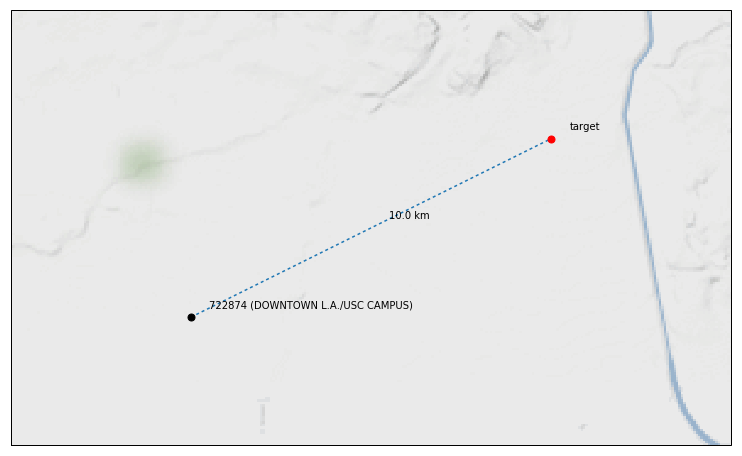

In [7]:
eeweather.plot_station_mapping(lat, lng, selected_station, distance_meters=10007)

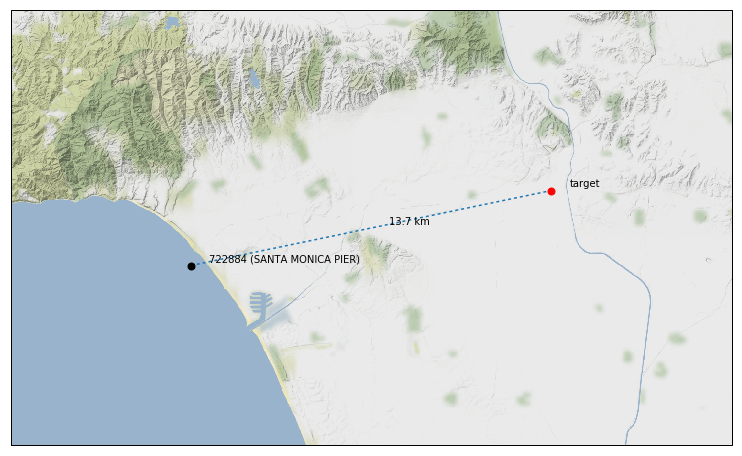

In [8]:
eeweather.plot_station_mapping(lat, lng, other_station, distance_meters=13693)

Oops! That match would have been off shore. We can eliminate poor matches like that by restricting on climate zones:

In [9]:
cz_stations = eeweather.rank_stations(
    lat, lng,
    match_iecc_climate_zone=True,
    match_iecc_moisture_regime=True,
    match_ba_climate_zone=True,
    match_ca_climate_zone=True,
)
cz_stations.head(10)

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
749169,1,13922.019458,34.133,-118.133,3,B,Hot-Dry,CA_09,low,231.0,CA,None,False,False,None
747041,2,19603.256230,34.083,-118.033,3,B,Hot-Dry,CA_09,low,91.1,CA,None,False,False,None
747043,3,19603.256230,34.083,-118.033,3,B,Hot-Dry,CA_09,low,90.2,CA,None,False,False,None
722880,4,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None
745057,5,28601.876717,34.259,-118.413,3,B,Hot-Dry,CA_09,low,305.7,CA,None,False,False,None
722886,6,29359.110925,34.210,-118.489,3,B,Hot-Dry,CA_09,high,234.7,CA,II,True,True,None
722887,7,42656.261633,34.100,-117.783,3,B,Hot-Dry,CA_09,low,308.2,CA,None,False,False,None
720046,8,47162.357478,34.370,-118.570,3,B,Hot-Dry,CA_09,low,427.0,CA,None,False,False,None


With that restriction, we only have eight potential matches left. A few more restrictions and we're left with only two possible matches:

In [10]:
cz_strict_stations = eeweather.rank_stations(
    lat, lng,
    match_iecc_climate_zone=True,
    match_iecc_moisture_regime=True,
    match_ba_climate_zone=True,
    match_ca_climate_zone=True,
    minimum_quality='high',  # find stations with reported high frequency data
    is_tmy3=True,            # find stations with TMY3 normal year data
    is_cz2010=True,          # find stations with CZ2010 normal year data
)
cz_strict_stations.head()

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722880,1,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None
722886,2,29359.110925,34.210,-118.489,3,B,Hot-Dry,CA_09,high,234.7,CA,II,True,True,None


The library is designed to provide some flexibility when selecting weather stations - allowing you to be as strict or as flexible as you'd like. You can also restrict on distance or elevation difference.

In [11]:
eeweather.rank_stations(
    lat, lng,
    match_iecc_climate_zone=True,
    match_iecc_moisture_regime=True,
    match_ba_climate_zone=True,
    match_ca_climate_zone=True,
    minimum_quality='high',
    is_tmy3=True,
    is_cz2010=True,
    max_distance_meters=25000,
)

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722880,1,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None


If you're too strict, you'll end up with no matches at all, so be careful.

In some cases, you'll want to have a "fallback" method for selecting a station if the preferred method does not succeed. For instance, you may first try to find an acceptable weather station in the same climate zone but fallback to a nearby station outside of the climate zone in the absence of a suitable match.

In [12]:
relaxed_stations = eeweather.rank_stations(
    lat, lng,
    minimum_quality='high',
    is_tmy3=True,
    is_cz2010=True,
)
relaxed_stations.head()

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722956,1,16045.497231,33.923,-118.334,3,B,Hot-Dry,CA_08,high,19.2,CA,II,True,True,None
722950,2,18139.293366,33.938,-118.389,3,B,Hot-Dry,CA_06,high,29.6,CA,I,True,True,None
722885,3,19716.198124,34.016,-118.451,3,B,Hot-Dry,CA_06,high,53.0,CA,II,True,True,None
722880,4,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None
722970,5,27256.365081,33.812,-118.146,3,B,Hot-Dry,CA_08,high,9.5,CA,I,True,True,None


The combine ranked stations helps create rankings which allow fallbacks, putting the `cz_strict` stations before the `relaxed` stations in order of preference.

In [13]:
combined_stations = eeweather.combine_ranked_stations([
    cz_strict_stations,
    relaxed_stations.head(10)
])

In [14]:
combined_stations

,rank,distance_meters,latitude,longitude,iecc_climate_zone,iecc_moisture_regime,ba_climate_zone,ca_climate_zone,rough_quality,elevation,state,tmy3_class,is_tmy3,is_cz2010,difference_elevation_meters
usaf_id,,,,,,,,,,,,,,,
722880,1,20445.357047,34.201,-118.358,3,B,Hot-Dry,CA_09,high,236.2,CA,II,True,True,None
722886,2,29359.110925,34.210,-118.489,3,B,Hot-Dry,CA_09,high,234.7,CA,II,True,True,None
722956,3,16045.497231,33.923,-118.334,3,B,Hot-Dry,CA_08,high,19.2,CA,II,True,True,None
722950,4,18139.293366,33.938,-118.389,3,B,Hot-Dry,CA_06,high,29.6,CA,I,True,True,None
722885,5,19716.198124,34.016,-118.451,3,B,Hot-Dry,CA_06,high,53.0,CA,II,True,True,None
722970,6,27256.365081,33.812,-118.146,3,B,Hot-Dry,CA_08,high,9.5,CA,I,True,True,None
722976,7,30836.134821,33.872,-117.979,3,B,Hot-Dry,CA_08,high,29.3,CA,II,True,True,None
722977,8,53264.955477,33.680,-117.866,3,B,Hot-Dry,CA_06,high,16.5,CA,II,True,True,None
722899,9,56358.973575,33.975,-117.636,3,B,Hot-Dry,CA_10,high,198.1,CA,III,True,True,None


Let's now take a look at the select station function more closely. Why does it exist? We already explored how easy it is to create an ISDStation object without using this function. It exists to help filter by data quality, which would be too computationally intensive without first filtering and ranking the candidate selections. This way, we start at the top and only check data quality on the stations that really matter.

Suppose we are interested in stations which have data with at least 99% coverage for all of 2017. Here's how we might do it.

In [15]:
start_date = datetime(2017, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2017, 12, 31, 23, tzinfo=pytz.UTC)
station, warnings = eeweather.select_station(
    combined_stations,
    coverage_range=(start_date, end_date),
    min_fraction_coverage=0.99,
    rank=1  # if you want the nth viable choice (e.g., to check fallbacks for data coverage, set rank=n)
)
station

ISDStation('722880')

What if you want to check that the selected weather station is within a certain distance (let's say 5 km). Use the distance_warnings parameter to list out what distances should produce warnings during station selection.

In [16]:
combined_stations.loc[station.usaf_id]

rank                                 1
distance_meters                20445.4
latitude                        34.201
longitude                     -118.358
iecc_climate_zone                    3
iecc_moisture_regime                 B
ba_climate_zone                Hot-Dry
ca_climate_zone                  CA_09
rough_quality                     high
elevation                        236.2
state                               CA
tmy3_class                          II
is_tmy3                           True
is_cz2010                         True
difference_elevation_meters       None
Name: 722880, dtype: object

In [30]:
start_date = datetime(2017, 1, 1, tzinfo=pytz.UTC)
end_date = datetime(2017, 12, 31, 23, tzinfo=pytz.UTC)
station, warnings = eeweather.select_station(
    combined_stations,
    coverage_range=(start_date, end_date),
    min_fraction_coverage=0.99,
    rank=1,  # if you want the nth viable choice (e.g., to check fallbacks for data coverage, set rank=n)
    distance_warnings=[5000]
)
warnings

[EEWeatherWarning(qualified_name=eeweather.exceeds_maximum_distance)]

In [31]:
warnings[0].data

{'distance_meters': 20445.357047313344, 'max_distance_meters': 5000}

We can be confident that this station `'722880'` has weather data for the requested period. The station object has plenty of metadata for us and can even serialize it into JSON:

In [17]:
print(json.dumps(station.json(), indent=2))

{
  "elevation": 236.2,
  "latitude": 34.201,
  "longitude": -118.358,
  "icao_code": "KBUR",
  "name": "BURBANK-GLENDALE-PASA ARPT",
  "quality": "high",
  "wban_ids": [
    "23152",
    "99999"
  ],
  "recent_wban_id": "23152",
  "climate_zones": {
    "iecc_climate_zone": "3",
    "iecc_moisture_regime": "B",
    "ba_climate_zone": "Hot-Dry",
    "ca_climate_zone": "CA_09"
  }
}


Best of all, now we can pull temperature data directly.

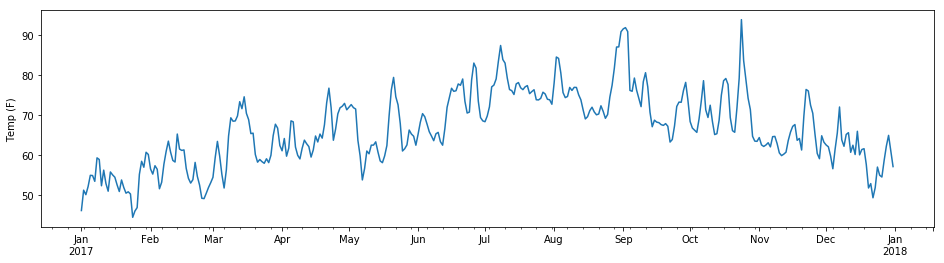

In [18]:
# pull temperature data over a range - make sure to use tz-aware datetimes!
temp_C = station.load_isd_daily_temp_data(start_date, end_date)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

This temperature data comes from the NOAA Integrated Surface Database (ISD). As alluded to earlier, data is also available for TMY3 and CZ2010 weather normal for some weather stations, including this one (that was one of our filtering criteria!).

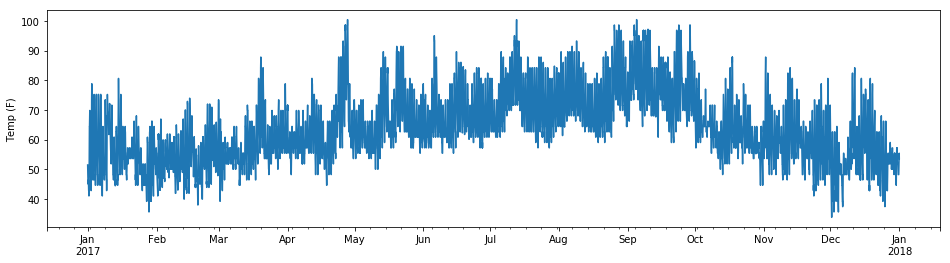

In [19]:
# pull normalized TMY3 temperature data over a range, tiling the normal year as necessary.
temp_C = station.load_tmy3_hourly_temp_data(start_date, end_date)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

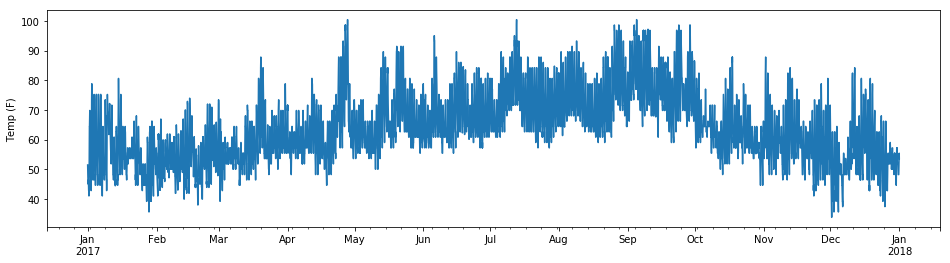

In [20]:
# pull normalized CZ2010 temperature data over a range, tiling the normal year as necessary
temp_C = station.load_cz2010_hourly_temp_data(start_date, end_date)
temp_F = temp_C * 1.8 + 32  # convert from Celsius to Fahrenheit
ax = temp_F.plot(figsize=(16,4))
ax.set_ylabel('Temp (F)')
plt.show()

There is plenty more to do with the library, including a host of functions for pulling raw data files and caching the results. Here's a taste:

In [21]:
# see raw data files - try downloading one of these!
station.get_isd_filenames(with_host=True)

['ftp://ftp.ncei.noaa.gov/pub/data/noaa/2006/722880-23152-2006.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2007/722880-23152-2007.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2008/722880-23152-2008.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2009/722880-23152-2009.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2010/722880-23152-2010.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2011/722880-23152-2011.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2012/722880-23152-2012.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2013/722880-23152-2013.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2014/722880-23152-2014.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2015/722880-23152-2015.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2016/722880-23152-2016.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2017/722880-23152-2017.gz',
 'ftp://ftp.ncei.noaa.gov/pub/data/noaa/2018/722880-23152-2018.gz']